In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from PIL import Image

## Histogram based analysis

In [3]:
mean = 0
stddev = 0.1

def create_noisy_image(mean, stddev):
    # create black image
    img_dim = (500,500)
    img = np.zeros(img_dim)

    #draw line on black img from p1 to p2. functions draws inplace.
    p1_1 = (75,100)   # (col,row)
    p1_2 = (300,450)

    p2_1 = (375, 50)
    p2_2 = (250,250)

    p3_1 = (50, 400)
    p3_2 = (225, 450)

    p4_1 = (20, 460)
    p4_2 = (80, 490)

    p5_1 = (150, 25)
    p5_2 = (250, 75)

    p6_1 = (100, 250)
    p6_2 = (100, 375)

    p7_1 = (200, 450)
    p7_2 = (100, 475)

    p8_1 = (300, 350)
    p8_2 = (400, 200)

    p9_1 = (75, 280)
    p9_2 = (25, 350)

    p0_1 = (200, 350)
    p0_2 = (150, 390)

    line_color=(255,255,255)
    cv2.line(img, p1_1, p1_2, color=line_color, thickness=2)
    cv2.line(img, p2_1, p2_2, color=line_color, thickness=2)
    cv2.line(img, p3_1, p3_2, color=line_color, thickness=2)
    cv2.line(img, p4_1, p4_2, color=line_color, thickness=2)
    cv2.line(img, p5_1, p5_2, color=line_color, thickness=2)
    cv2.line(img, p6_1, p6_2, color=line_color, thickness=2)
    cv2.line(img, p7_1, p7_2, color=line_color, thickness=2)
    cv2.line(img, p8_1, p8_2, color=line_color, thickness=2)
    cv2.line(img, p9_1, p9_2, color=line_color, thickness=2)
    cv2.line(img, p0_1, p0_2, color=line_color, thickness=2)
    

    # scale and normalize img
    img = (img*150/255+50)/255

    # add noise to img
    gauss_noise = np.random.normal(mean, stddev, img_dim)
    img_gauss = cv2.add(img,gauss_noise)
    # # normalize
    img_gauss = (img_gauss - np.min(img_gauss)) / (np.max(img_gauss)-np.min(img_gauss))

    return img, img_gauss


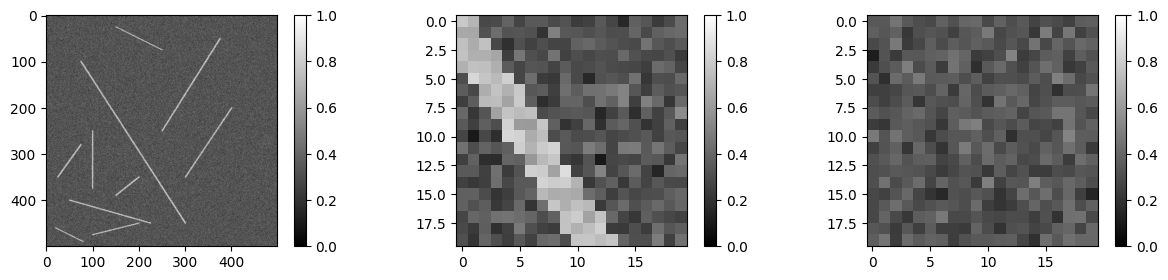

In [4]:

img_no_noise, img_gauss = create_noisy_image(mean, stddev)
small_img_gauss_line=img_gauss[200:220,140:160]
small_img_gauss_no_line = img_gauss[50:70,50:70]

# set common color range
vmin = min(img_gauss.min(), small_img_gauss_line.min(), small_img_gauss_no_line.min())
vmax = max(img_gauss.max(), small_img_gauss_line.max(), small_img_gauss_no_line.max())

fig, ax = plt.subplots(1, 3, figsize=(15,3))

im0 = ax[0].imshow(img_gauss, cmap='gray', vmin=vmin, vmax=vmax)
im1 = ax[1].imshow(small_img_gauss_line, cmap='gray', vmin=vmin, vmax=vmax)
im2 = ax[2].imshow(small_img_gauss_no_line, cmap='gray', vmin=vmin, vmax=vmax)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
plt.show()

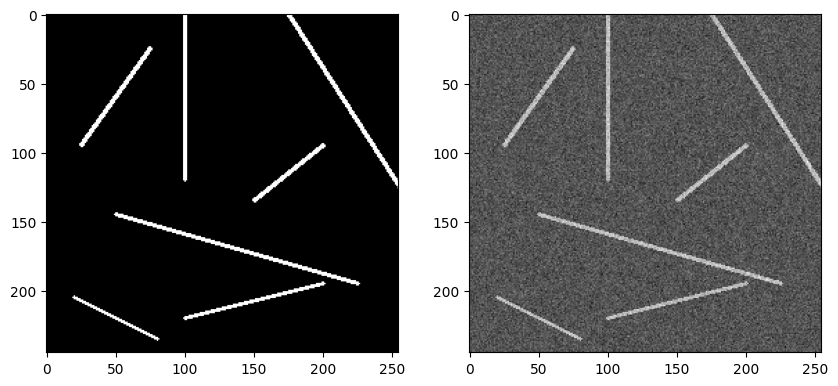

In [5]:
img_gauss_ex = img_gauss[255:, :255]
img_no_noise_ex = img_no_noise[255:, :255]

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(img_no_noise_ex, cmap='gray')
ax[1].imshow(img_gauss_ex, cmap='gray')
plt.show()



### Gaussian mixture model of the histogram

In [6]:

def create_hist_gmm(data, n_components):
    num_bins = math.floor(np.sqrt(data.size))#max(10, data.shape[0]//2)
    counts, bin_edges = np.histogram(data, bins=num_bins)

    data = data.ravel()

    gmm = GaussianMixture(n_components)
    gmm.fit(data.reshape(-1,1))

    x = np.linspace(bin_edges[0], bin_edges[-1], 1000).reshape(-1,1)
    y = np.exp(gmm.score_samples(x)) # probabilities of a point belonging to a cluster??


    return counts, bin_edges, x, y

In [7]:
h1, b1, x1, g1 = create_hist_gmm(img_gauss, 1)
h2, b2, x2, g2 = create_hist_gmm(img_gauss, 2)

h1_small, b1_small, x1_small, g1_small = create_hist_gmm(small_img_gauss_line,1)
h2_small, b2_small, x2_small, g2_small = create_hist_gmm(small_img_gauss_line,2)

h1_no_line, b1_no_line, x1_no_line, g1_no_line = create_hist_gmm(small_img_gauss_no_line,1)
h2_no_line, b2_no_line, x2_no_line, g2_no_line = create_hist_gmm(small_img_gauss_no_line,2)

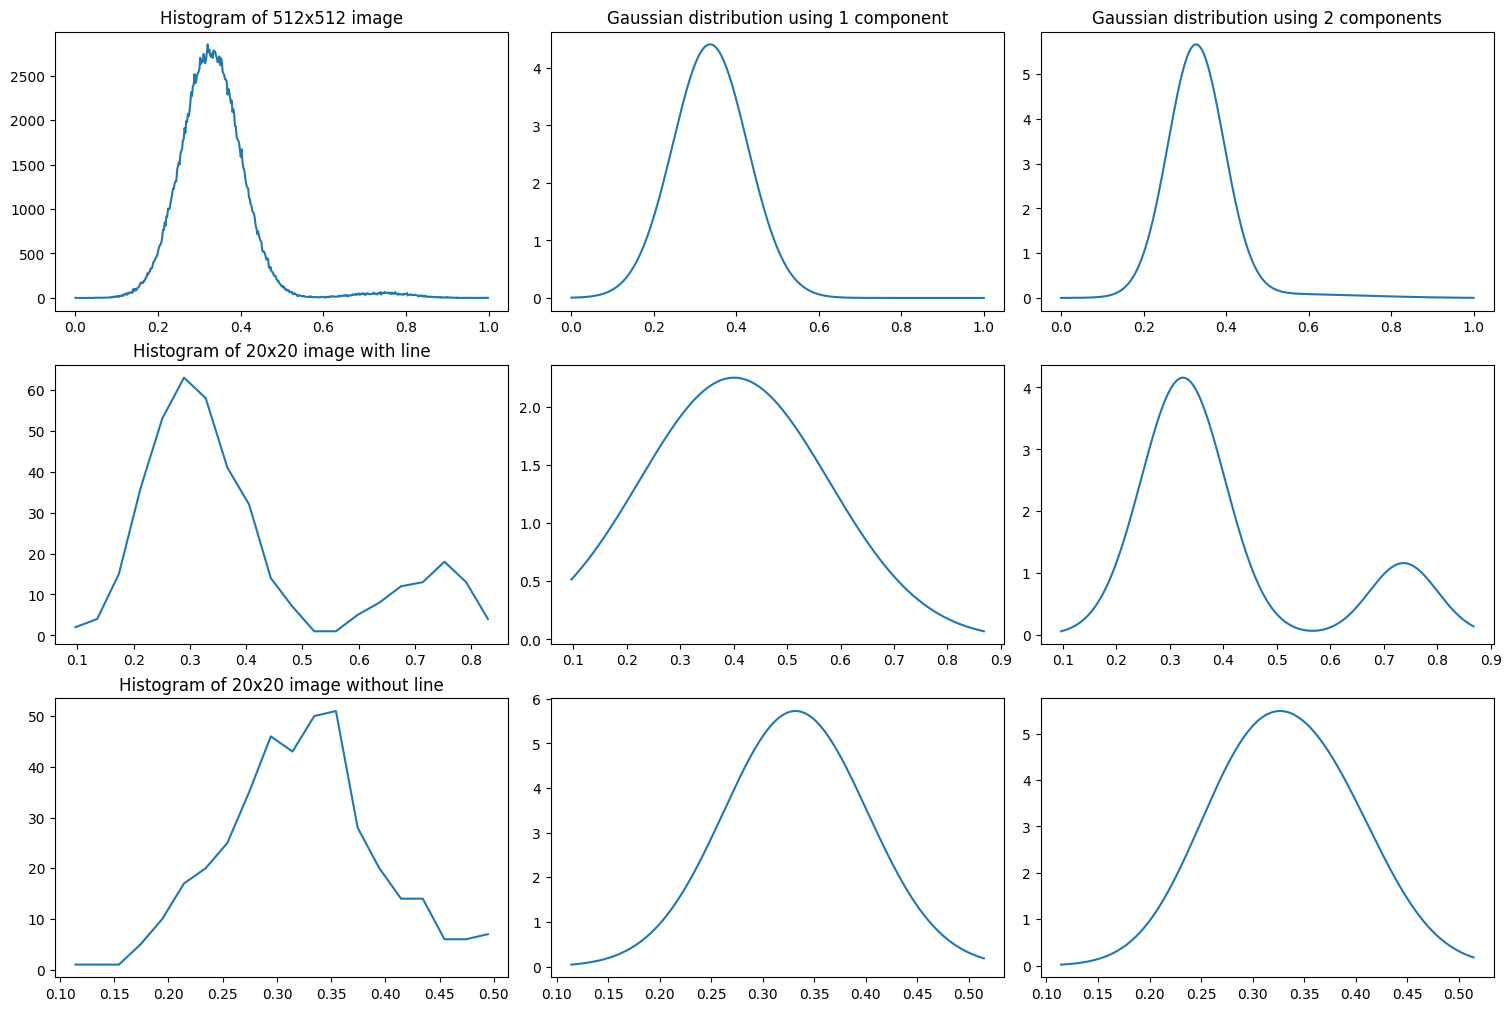

In [8]:
fig, ax = plt.subplots(3,3, layout='constrained', figsize=(15,10))
ax[0][0].set_title("Histogram of 512x512 image")
ax[0][1].set_title('Gaussian distribution using 1 component')
ax[0][2].set_title('Gaussian distribution using 2 components')

ax[0][0].plot(b1[0:-1], h1)
ax[0][1].plot(x1,g1)
ax[0][2].plot(x1,g2)

ax[1][0].set_title("Histogram of 20x20 image with line")
ax[1][0].plot(b1_small[0:-1], h1_small)
ax[1][1].plot(x1_small,g1_small)
ax[1][2].plot(x1_small,g2_small)

ax[2][0].set_title("Histogram of 20x20 image without line")
ax[2][0].plot(b1_no_line[0:-1], h1_no_line)
ax[2][1].plot(x1_no_line,g1_no_line)
ax[2][2].plot(x1_no_line,g2_no_line)

plt.show()

In [9]:
# # Kullback-Leibler (KL) divergence: a measure of how different the distributions are.

kl_divergence_img = entropy(g1,g2, base=2)
kl_divergence_small = entropy(g1_small, g2_small, base=2)
kl_divergence_no_line = entropy(g1_no_line, g2_no_line, base=2)

print("KL divergence between 1 and 2 components on original image", kl_divergence_img)
print("KL divergence between 1 and 2 components on small image", kl_divergence_small)
print("KL divergence between 1 and 2 components on no line image", kl_divergence_no_line)

KL divergence between 1 and 2 components on original image 0.10973068444005578
KL divergence between 1 and 2 components on small image 0.7544631718185317
KL divergence between 1 and 2 components on no line image 0.002046412472379743


### Gradient lengths to determine lines

In [10]:
def gradient_length(image, ksize):
    # Apply the Sobel operator
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize)

    gradient = np.sqrt(sobelx**2 + sobely**2)

    return gradient

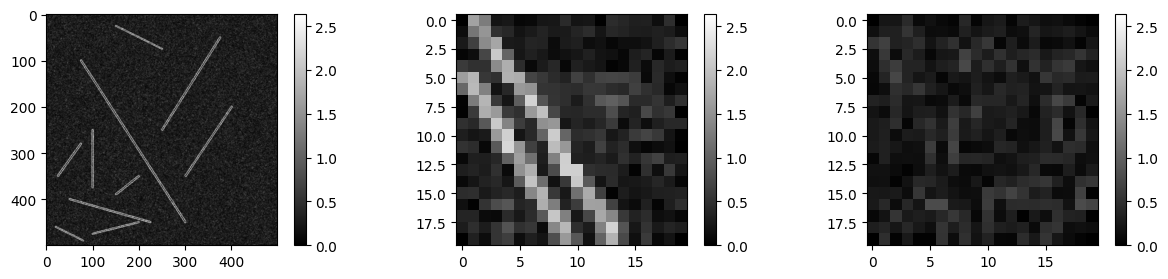

In [11]:
grad_len = gradient_length(img_gauss, 3)
grad_len_small = gradient_length(small_img_gauss_line,3)
grad_len_no_line = gradient_length(small_img_gauss_no_line, 3)

vmin = min(grad_len.min(), grad_len_small.min(), grad_len_no_line.min())
vmax = max(grad_len.max(), grad_len_small.max(), grad_len_no_line.max())

fig, ax = plt.subplots(1, 3, figsize=(15,3))

im0 = ax[0].imshow(grad_len, cmap='gray', vmin=vmin, vmax=vmax)
im1 = ax[1].imshow(grad_len_small, cmap='gray', vmin=vmin, vmax=vmax)
im2 = ax[2].imshow(grad_len_no_line, cmap='gray', vmin=vmin, vmax=vmax)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
plt.show()

In [12]:
gl_diff_orig = np.max(grad_len) - np.min(grad_len)
gl_diff_small = np.max(grad_len_small) - np.min(grad_len_small)
gl_diff_no_line = np.max(grad_len_no_line) - np.min(grad_len_no_line)

print(f"Difference between gradient lengths in original image: \t {gl_diff_orig}")
print(f"Difference between gradient lengths in small image: \t {gl_diff_small}")
print(f"Difference between gradient lengths in no line image: \t {gl_diff_no_line}")

Difference between gradient lengths in original image: 	 2.6347596183903086
Difference between gradient lengths in small image: 	 2.21943477608461
Difference between gradient lengths in no line image: 	 0.7774921536163144


## Histograms vs gradient lengths

In [14]:
def sample_patches(img, mask, ksize, iter):
    img_dim = img.shape[0]
    split = iter//2

    pos = []
    neg = []
    pos_mask = []
    neg_mask = []
    pos_coordinates = []
    neg_coordinates = []

    while (not len(pos)==split) or (not len(neg)==split):
        i = np.random.randint(0, img_dim-ksize)
        j = np.random.randint(0, img_dim-ksize)
        img_patch = img[i:i+ksize, j:j+ksize]
        mask_patch = mask[i:i+ksize, j:j+ksize]
        if (len(np.unique(mask_patch)) == 2) and (len(pos) < split):
            pos.append(img_patch)
            pos_mask.append(mask_patch)
            pos_coordinates.append((j,i))
        elif (len(np.unique(mask_patch)) == 1) and (len(pos) >= split):
            pass
        elif (len(np.unique(mask_patch)) == 1) and (len(neg) < split):
            neg.append(img_patch)
            neg_mask.append(mask_patch)
            neg_coordinates.append((j,i))
        else:
            pass

    samples = pos + neg
    masks = pos_mask + neg_mask
    coordinates = pos_coordinates + neg_coordinates

    # random permutation index
    perm_idx = np.random.permutation(len(samples))

    samples = [samples[i] for i in perm_idx]
    masks = [masks[i] for i in perm_idx]
    coordinates = [coordinates[i] for i in perm_idx]

    return samples, masks, coordinates

In [15]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

In [67]:
def hist_detection(samples, masks):
    hist_detects = []
    ground_truths = []

    for i in range(len(samples)):
        ground_truth = (len(np.unique(masks[i])) > 1)
        
        _, _, _, g1 = create_hist_gmm(samples[i], n_components=1)
        _, _, _, g2 = create_hist_gmm(samples[i], n_components=2)

        kl_div = (entropy(g1, g2, base=2) + entropy(g2, g1, base=2))/ 2

        hist_detects.append(kl_div)
        ground_truths.append(int(ground_truth))

    return min_max_normalize(hist_detects), ground_truths

def grad_detection(samples, masks, k):
    gl_diffs = []
    ground_truths = []

    for i in range(len(samples)):
        ground_truth = (len(np.unique(masks[i])) > 1)

        grad_len = gradient_length(samples[i], k)
        gl_diff = np.max(grad_len) - np.min(grad_len)

        gl_diffs.append(gl_diff)
        ground_truths.append(int(ground_truth))
    return min_max_normalize(gl_diffs), ground_truths

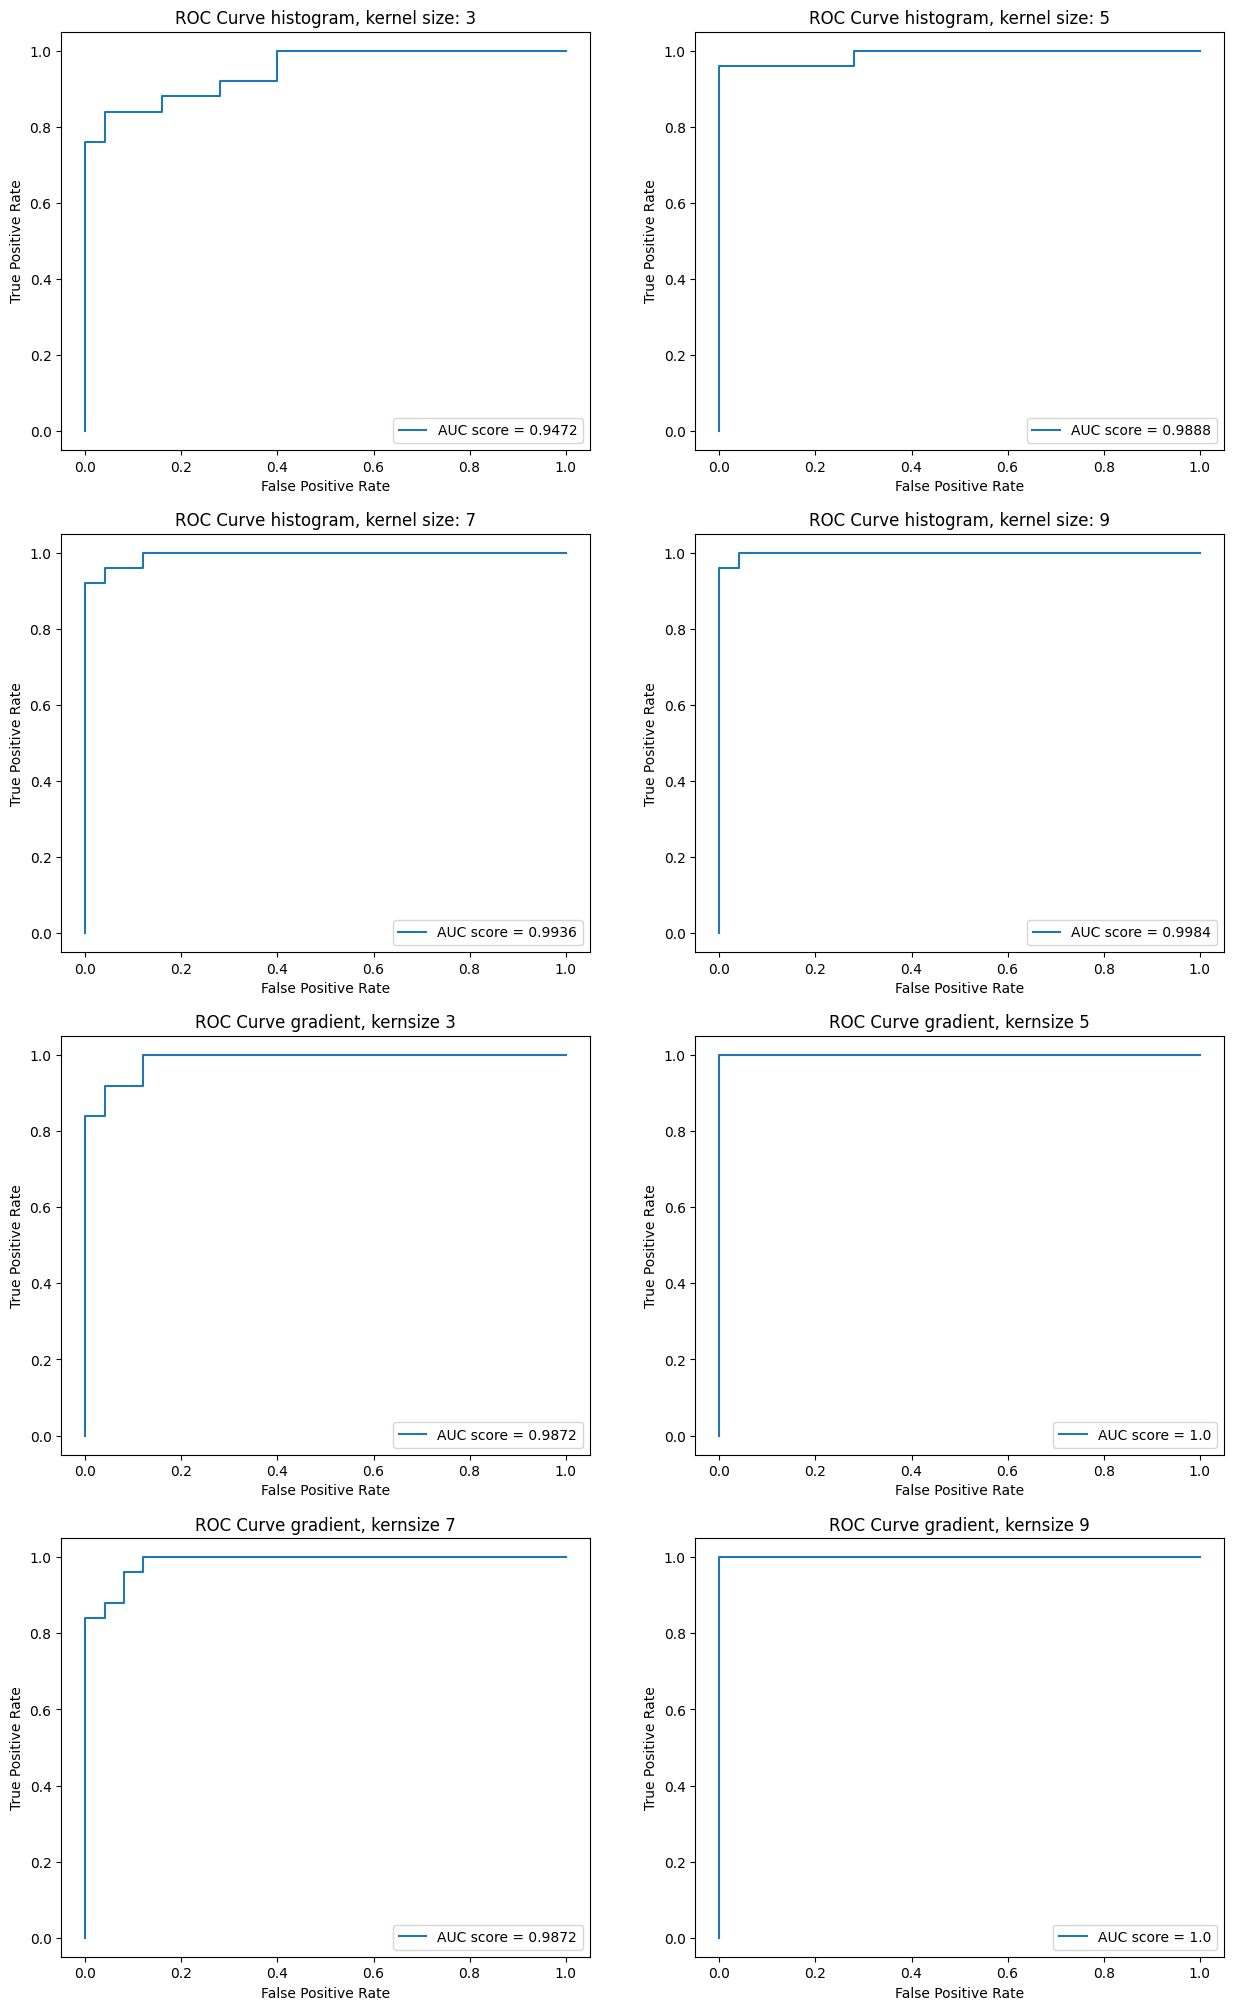

In [68]:
# run experiment
np.random.seed(1)

kern_sizes = [3,5,7,9]

iter = 50

fig, ax = plt.subplots(4,2,figsize=(15,25))

for i, k in enumerate(kern_sizes):

    samples, masks, coordinates = sample_patches(img_gauss_ex, img_no_noise_ex, k, iter)
   
    kl_div, ground_truth = hist_detection(samples, masks)
    fpr_hist, tpr_hist, ts_hist = roc_curve(ground_truth, kl_div, drop_intermediate=False)
    hist_auc = roc_auc_score(ground_truth, kl_div)

    gl_diffs, ground_truth = grad_detection(samples, masks, k)
    fpr_grad, tpr_grad, ts_grad = roc_curve(ground_truth, gl_diffs, drop_intermediate=False)
    grad_auc = roc_auc_score(ground_truth,gl_diffs)

    # Plot the ROC curves
    if i < 2:
        ax[0][i].plot(fpr_hist, tpr_hist, label=f'AUC score = {hist_auc}')
        ax[0][i].set_xlabel('False Positive Rate')
        ax[0][i].set_ylabel('True Positive Rate')
        ax[0][i].set_title(f'ROC Curve histogram, kernel size: {k}')
        ax[0][i].legend(loc='lower right')
    
        ax[2][i].plot(fpr_grad, tpr_grad, label=f'AUC score = {grad_auc}')
        ax[2][i].set_xlabel('False Positive Rate')
        ax[2][i].set_ylabel('True Positive Rate')
        ax[2][i].set_title(f'ROC Curve gradient, kernsize {k}')
        ax[2][i].legend(loc='lower right')
    else:
        ax[1][i-2].plot(fpr_hist, tpr_hist, label=f'AUC score = {hist_auc}')
        ax[1][i-2].set_xlabel('False Positive Rate')
        ax[1][i-2].set_ylabel('True Positive Rate')
        ax[1][i-2].set_title(f'ROC Curve histogram, kernel size: {k}')
        ax[1][i-2].legend(loc='lower right')
    
        ax[3][i-2].plot(fpr_grad, tpr_grad, label=f'AUC score = {grad_auc}')
        ax[3][i-2].set_xlabel('False Positive Rate')
        ax[3][i-2].set_ylabel('True Positive Rate')
        ax[3][i-2].set_title(f'ROC Curve gradient, kernsize {k}')
        ax[3][i-2].legend(loc='lower right')
plt.show()

### Structure tensors

In [ ]:
""" 
create and image with multiple lines and other shapes as well. 
then calculate the structure tensor to and use them to compute edge information in that image. 
By computing the eigenvectors of the structure tensor at each pixel in an image, we can determine the orientation of the local edges. This information can then be used to segment the image by grouping pixels with similar edge orientations and/or strengths. For example, pixels with similar orientations could be clustered together to form edges, which could then be used to separate regions with different textures.
"""

' \ncreate and image with multiple lines and other shapes as well. \nthen calculate the structure tensor to and use them to compute edge information in that image. \nBy computing the eigenvectors of the structure tensor at each pixel in an image, we can determine the orientation of the local edges. This information can then be used to segment the image by grouping pixels with similar edge orientations and/or strengths. For example, pixels with similar orientations could be clustered together to form edges, which could then be used to separate regions with different textures.\n'

## Try with legit image

In [ ]:
test = np.array(Image.open("/Users/leeannquynhdo/Datalogi/MSc_thesis/unet_implementation/train_image_patch/patch_512_0.png").convert('L'))

print(test.shape)
print(test)

(512, 512)
[[101  86  93 ... 138 182 226]
 [ 93  99  73 ... 189 146 228]
 [ 84 111  81 ... 157 103 228]
 ...
 [ 82 101 148 ... 158 192 141]
 [ 97 116 135 ... 137 141 138]
 [116 106 147 ... 113 155 148]]


In [ ]:
h1_test, b1_test, x1_test, g1_test = create_hist_gmm(test,1)
h2_test, b2_test, x2_test, g2_test = create_hist_gmm(test,2)

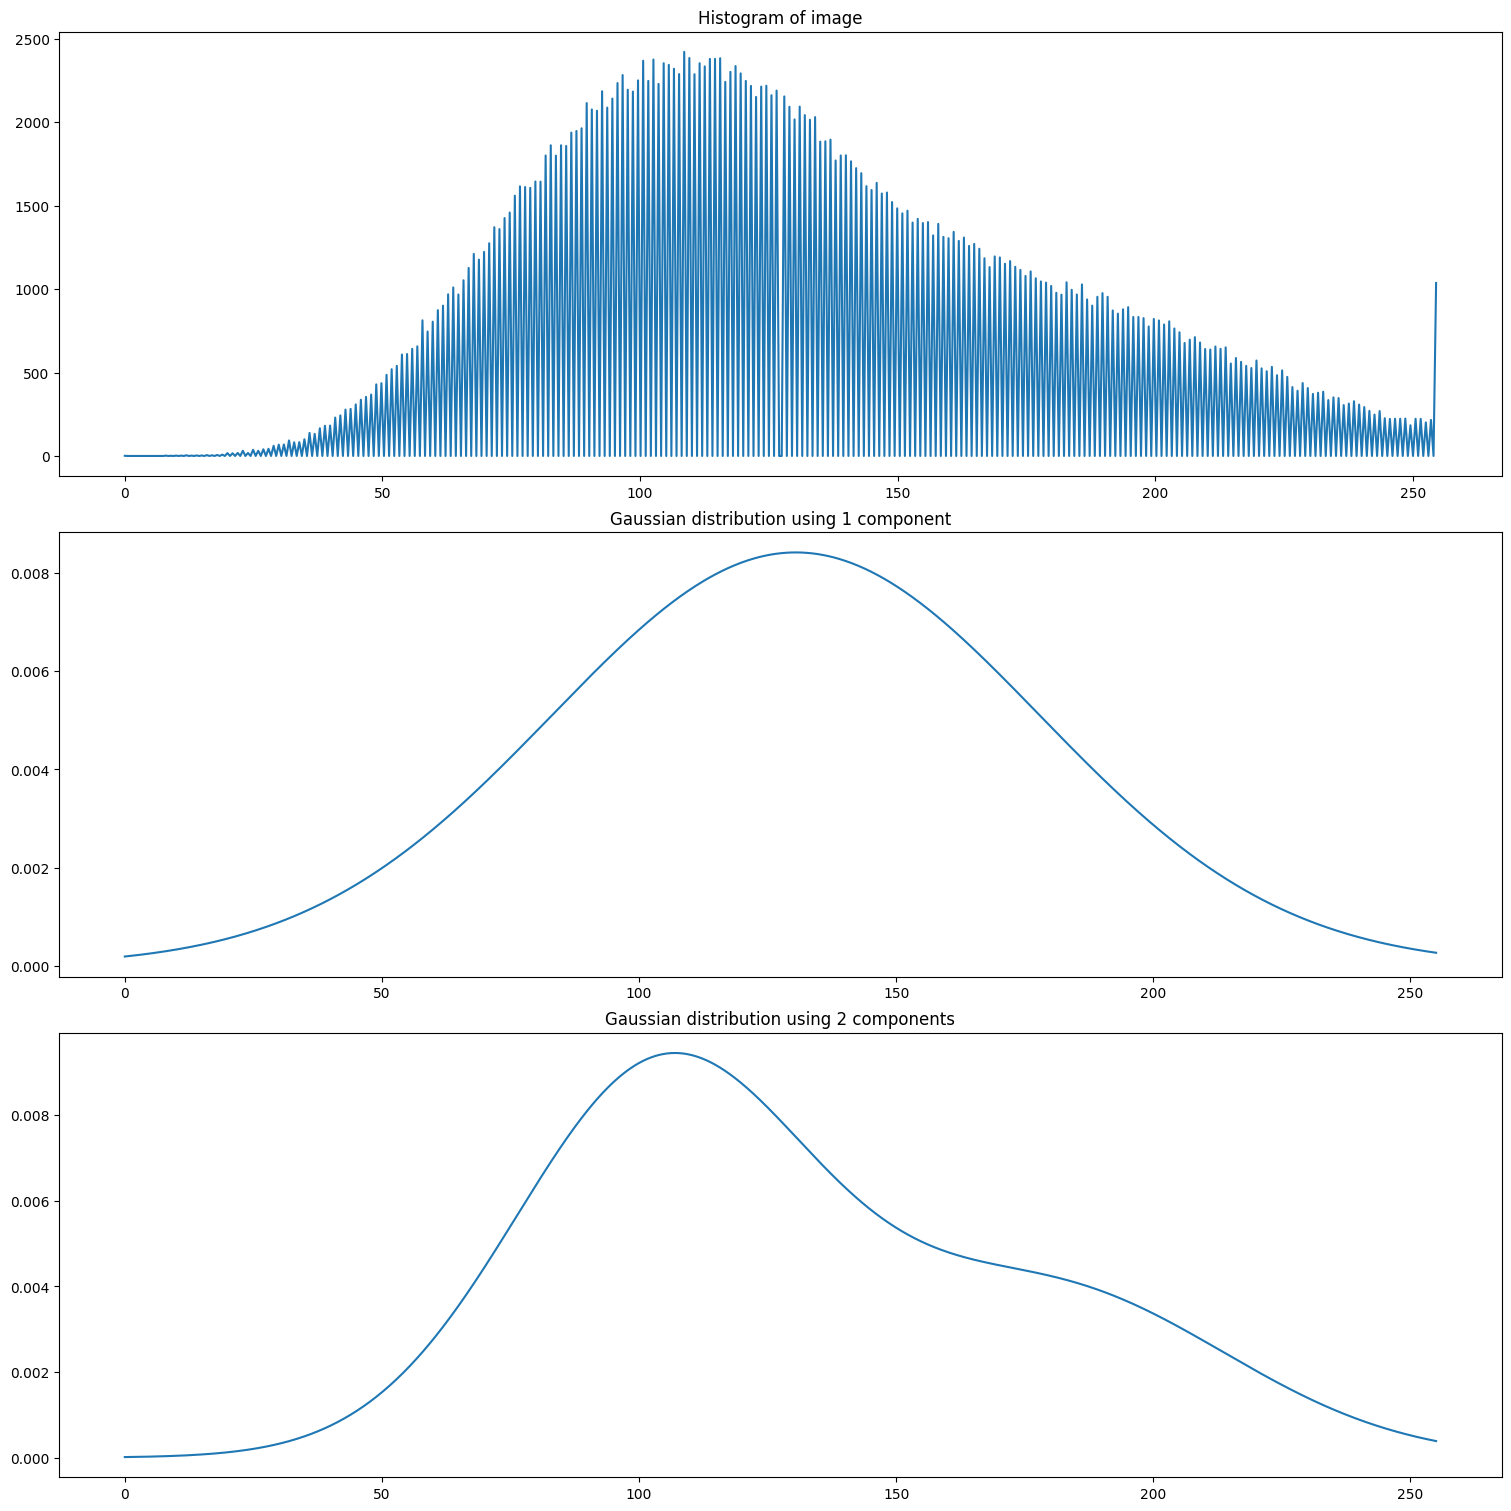

In [ ]:
fig, ax = plt.subplots(3,1, layout='constrained', figsize=(15,15))

ax[0].set_title("Histogram of image")
ax[1].set_title('Gaussian distribution using 1 component')
ax[2].set_title('Gaussian distribution using 2 components')

ax[0].plot(b1_test[0:-1], h1_test)
ax[1].plot(x1_test,g1_test)
ax[2].plot(x1_test,g2_test)

plt.show()

In [ ]:
seg1 = (test <= 55)
seg2 = (test > 55) & (test <= 70)
seg3 = (test > 70) & (test <= 85)
seg4 = (test > 85) & (test <= 100)
seg5 = (test > 100) & (test <= 125)
seg6 = (test > 125) & (test <= 160)
seg7 = (test > 160) & (test <= 200)
seg8 = (test > 200) & (test <= 240)
seg9 = (test > 240)

(512, 512, 3)


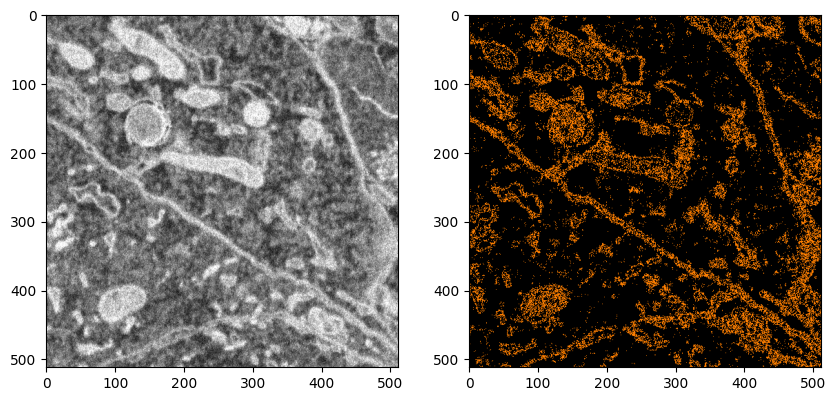

In [ ]:
all_seg = np.zeros((test.shape[0], test.shape[1], 3))

print(all_seg.shape)

# all_seg[seg1] = (255,0,0) # red
# all_seg[seg2] = (0,255,0) # green
# all_seg[seg3] = (0,0,1) # blue
# all_seg[seg4] = (1,1,0) # yellow 
# all_seg[seg5] = (1,0,1) # magenta
# all_seg[seg6] = (0,1,1) # cyan
all_seg[seg7] = (1,0.5,0) # orange
# all_seg[seg8] = (1, 0.75, 0.79) # pink
# all_seg[seg9] = (1,1,1) # white

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test, cmap='gray')
ax[1].imshow(all_seg)
plt.show()



##### Function to loop over image and determine if there is a line given the histogram(?)